In [66]:
using Plots
pyplot()

Plots.PyPlotBackend()

HermiteGf is a julia package, install it with

```julia
using Pkg
Pkg.add("https://gitlab.mpcdf.mpg.de/clapp/HermiteGF.jl")
```

In [67]:
using HermiteGF

In [83]:
import HermiteGF:trapz

In [85]:
xmin, xmax, nx = -1, 1, 32
interp = Hermite(Chebyshev(xmin, xmax, nx), 0.1, 3)    
xk = interp.xk
f  =  cos.(xk.^2)
xe = collect(range(xmin, stop=xmax, length=nx))
dx = xe[2]-xe[1]
fe = cos.(xe.^2)
s  = interpolate( interp, f, xe )
sqrt(trapz((s - fe).^2, dx)), maximum(abs.(s .- fe))

(1.717752537199409e-15, 5.662137425588298e-15)

In [ ]:
xmin, xmax, nx = -1, 1, 8
xe = collect(range(xmin, stop=xmax, length=nx))
fe = cos.(xe.^2)

In [ ]:
hermite_chebyshev = Hermite(Chebyshev(xmin, xmax, nx), 0.1, 3)
xk = hermite_chebyshev.xk
f  =  cos.(xk.^2)
scatter(xe, interpolate( hermite_chebyshev, f, xe ); 
    label = "chebyshev")
plot!(xe, fe; label="f", title="Hermite-Chebyshev")

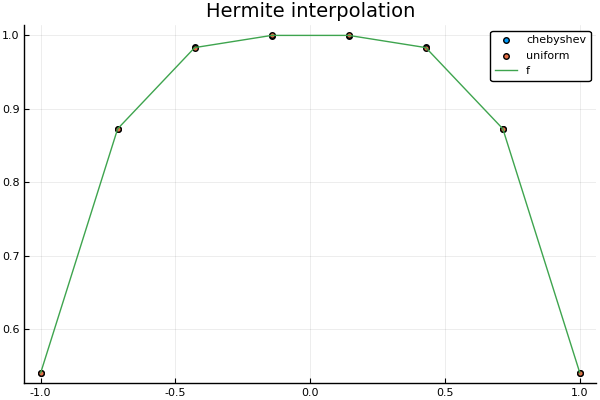

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [87]:
hermite_uniform  = Hermite(Uniform( xmin, xmax, nx), 0.1, 3)
xk = hermite_uniform.xk
f  =  cos.(xk.^2)
scatter!(xe, interpolate( hermite_uniform, f, xe ); 
    label="uniform")
plot!(xe, fe; label="f", title="Hermite-Uniform")